<a href="https://colab.research.google.com/github/Goggxi/Covid19-CNN-Skripsi/blob/main/Covid19-CNN-Skripsi-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install gdown

In [5]:
!gdown https://drive.google.com/uc?id=1lcXtzrU9jQ6Vxora7zwM_uSS1gHWvRFv

Downloading...
From: https://drive.google.com/uc?id=1lcXtzrU9jQ6Vxora7zwM_uSS1gHWvRFv
To: /content/data.zip
165MB [00:05, 31.9MB/s]


In [6]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/test/
   creating: data/test/Covid/
  inflating: data/test/Covid/0100.jpeg  
  inflating: data/test/Covid/0102.jpeg  
  inflating: data/test/Covid/0105.png  
  inflating: data/test/Covid/0106.jpeg  
  inflating: data/test/Covid/0108.jpeg  
  inflating: data/test/Covid/0111.jpg  
  inflating: data/test/Covid/0112.jpg  
  inflating: data/test/Covid/0113.jpg  
  inflating: data/test/Covid/0115.jpeg  
  inflating: data/test/Covid/0118.jpeg  
  inflating: data/test/Covid/0119.jpeg  
  inflating: data/test/Covid/0120.jpg  
  inflating: data/test/Covid/094.png  
  inflating: data/test/Covid/096.png  
  inflating: data/test/Covid/098.jpeg  
  inflating: data/test/Covid/auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg  
  inflating: data/test/Covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: data/test/Covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavir

In [7]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [8]:
!ls data/
!ls data/train
!ls data/train/Covid/
!ls data/train/Normal/
!ls data/train/Viral\ Pneumonia

test  train
 Covid	 Normal  'Viral Pneumonia'
010.png   045.jpeg  069.jpg   09.png		COVID-00020.jpg
012.jpeg  046.jpeg  06.jpeg   COVID-00001.jpg	COVID-00021.jpg
015.jpg   047.jpeg  071.jpg   COVID-00002.jpg	COVID-00022.jpg
019.png   048.jpeg  072.jpeg  COVID-00003a.jpg	COVID-00023.jpg
01.jpeg   049.jpeg  073.jpg   COVID-00003b.jpg	COVID-00024.jpg
020.jpg   04.png    074.jpg   COVID-00004.jpg	COVID-00025.jpg
021.jpeg  050.jpeg  076.jpg   COVID-00005.jpg	COVID-00026.jpg
022.jpeg  051.jpeg  078.jpeg  COVID-00006.jpg	COVID-00027.jpg
024.jpeg  052.jpeg  079.jpeg  COVID-00007.jpg	COVID-00028.jpg
025.jpeg  053.jpeg  07.jpg    COVID-00008.jpg	COVID-00029.jpg
026.jpeg  054.jpeg  080.jpg   COVID-00009.jpg	COVID-00030.jpg
027.jpeg  055.jpeg  081.jpeg  COVID-00010.jpg	COVID-00031.jpg
02.jpeg   056.jpg   082.jpg   COVID-00011.jpg	COVID-00032.jpg
031.jpeg  057.jpeg  083.jpeg  COVID-00012.jpg	COVID-00033.jpg
032.jpeg  058.jpeg  084.jpeg  COVID-00013a.jpg	COVID-00034.jpg
033.png   059.jpeg  085.jpeg 

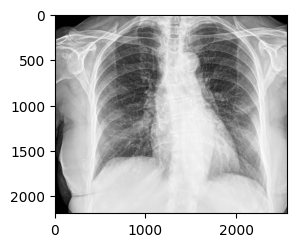

In [9]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/train/Covid/04.png")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [10]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
X_train = []
y_train = []
labels = ['Covid', 'Normal', 'Viral Pneumonia']

for i,label in enumerate(labels):
    folder = os.path.join("data/train/",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpeg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Covid', 'Normal', 'Viral Pneumonia']

for i,label in enumerate(labels):
    folder = os.path.join("data/test/",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpeg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Bentuk array dari dataset train (pelatihan) adalah:", X_train.shape,y_train.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (186, 224, 224, 3) (186,)
Bentuk array dari dataset test (pengujian) adalah: (52, 224, 224, 3) (52,)


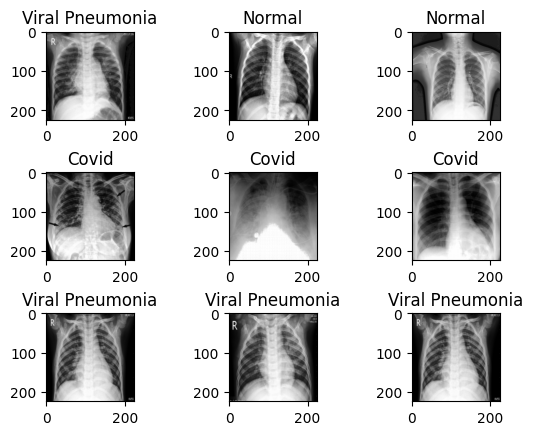

In [11]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#Menampilkan beberapa gambar dari dataset pelatihan secara acak
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Covid"
    elif y_train[idx] == 1:
        label = "Normal"
    else:
        label = "Viral Pneumonia"
    plt.title(label)
    plt.imshow(X_train[idx])

In [12]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [13]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, train_size=0.8, random_state=42)
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [148]:
model = Sequential([
    layers.Conv2D(3, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)), 
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),   
    layers.Flatten(),
    layers.Dense(4096),
    layers.Dropout(0.1),
    layers.Dense(3),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])

In [149]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi Covid-19.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x = X_train3, y = y_train3, batch_size=1000, epochs= 500,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 1.0909 - acc: 0.3649
Epoch 00001: val_loss improved from inf to 2.65214, saving model to Klasifikasi Covid-19.h5
1/1 [==============================] - 0s 416ms/step - loss: 1.0909 - acc: 0.3649 - val_loss: 2.6521 - val_acc: 0.2632
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 2.1581 - acc: 0.4054
Epoch 00002: val_loss improved from 2.65214 to 1.15103, saving model to Klasifikasi Covid-19.h5
1/1 [==============================] - 3s 3s/step - loss: 2.1581 - acc: 0.4054 - val_loss: 1.1510 - val_acc: 0.4474
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 1.1925 - acc: 0.3581
Epoch 00003: val_loss improved from 1.15103 to 1.03125, saving model to Klasifikasi Covid-19.h5
1/1 [==============================] - 0s 400ms/step - loss: 1.1925 - acc: 0.3581 - val_loss: 1.0313 - val_acc: 0.4474
Epoch 4/500
1/1 [==============================] - ETA: 0s - loss: 1.0869 - acc: 0.3581
Epoch 0000

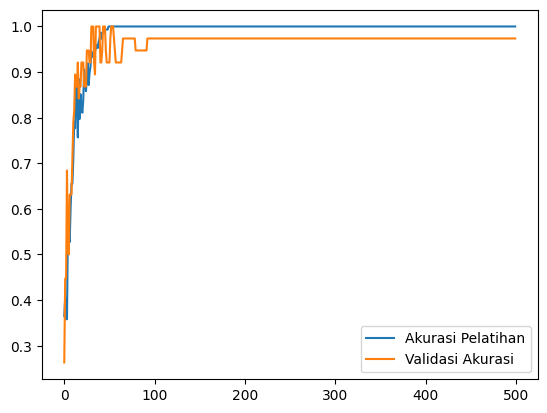

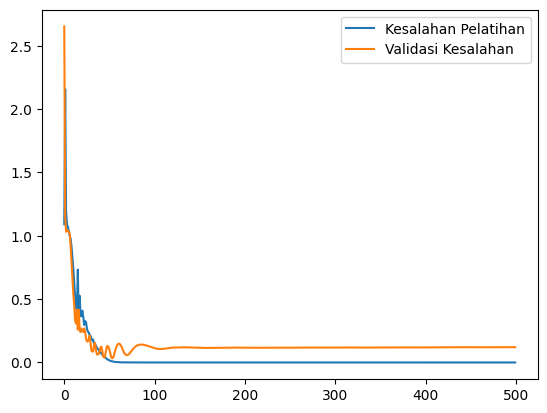

In [150]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [151]:
print(X_train3.shape)

(148, 224, 224, 3)


In [152]:
n = 8
input_image = X_train3[n][np.newaxis,...]
print("Labelnya adalah: ", y_train3[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah [1.3676196e-19 9.9999774e-01 2.3186071e-06]


In [153]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model.load_weights("Klasifikasi Covid-19.h5")

In [154]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= X_train3, y = y_train3))
#Evaluasi validasi data
print(model.evaluate(x= X_valid3, y = y_valid3))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
5/5 [==============================] - 0s 9ms/step - loss: 0.0077 - acc: 1.0000
[0.0077175842598080635, 1.0]
2/2 [==============================] - 0s 3ms/step - loss: 0.0323 - acc: 1.0000
[0.032326918095350266, 1.0]
2/2 [==============================] - 0s 5ms/step - loss: 0.1149 - acc: 0.9423
[0.11486147344112396, 0.942307710647583]


In [155]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1]


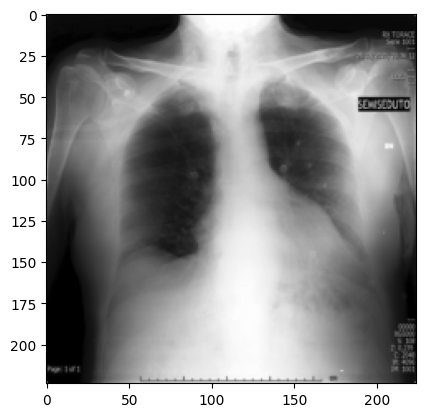

Label yang benar adalah: 0 : Covid
Nilai yang diprediksi adalah: [9.4959056e-01 4.9850814e-02 5.5869849e-04]
Label yang diprediksi adalah: 0 : Covid
Prediksi benar


In [163]:
n = 5 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")